In [26]:
import os
import gzip
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt

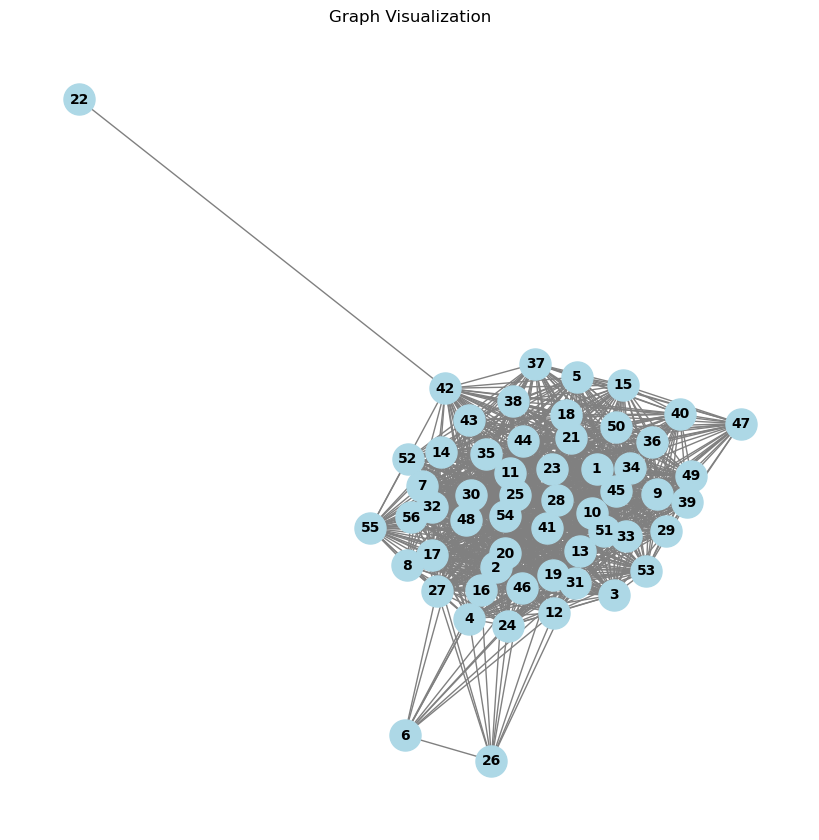

In [27]:
name = "insecta-ant-colony1-day38"
graph_path = f"./data_QOLIB/07-independentset/instances/{name}.gph"

def read_gph(filename):
    G = nx.Graph()
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('c'):  # skip comments
                continue
            parts = line.split()
            if parts[0] == 'p':
                # p edge <#nodes> <#edges>
                num_nodes = int(parts[2])
                # Add all nodes explicitly
                G.add_nodes_from(range(1, num_nodes + 1))
            elif parts[0] == 'e':
                # e <u> <v>
                u, v = map(int, parts[1:3])
                G.add_edge(u, v)
    return G

G = read_gph(graph_path)

# draw
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', edge_color='gray')
plt.title("Graph Visualization")
plt.show()

In [28]:
N = G.number_of_nodes()
Q = np.zeros((N, N))

# Linear terms
for i in range(N):
    Q[i, i] = -1

# Quadratic terms
for u, v in G.edges():
    Q[u-1, v-1] = 1
    Q[v-1, u-1] = 1

def qubo(Q):
    Q = 0.5 * (Q + Q.T)
    # Return J, h
    N = Q.shape[0]
    J = {}
    h = {}
    for i in range(N):
        for j in range(i + 1, N):
            J[(i, j)] = Q[i, j] + Q[j, i]
        h[i] = Q[i, i]
    return J, h

J, h = qubo(Q)

with open(f"./data/MIS/QUBO/qubo_{name}.json", "w") as f:
    json.dump({"J": {f"{k[0]},{k[1]}": v for k, v in J.items()}, "h": {str(k): v for k, v in h.items()}}, f, indent=4)

In [29]:
def qubo_to_ising(Q):
    """
    Convert a QUBO matrix Q to Ising model parameters J and h.
    Q: numpy array (n x n), not necessarily symmetric.
    Returns:
        J: dict of (i, j): value for i < j
        h: dict of i: value
    """
    Q = np.array(Q)
    Q = (Q + Q.T) / 2

    n = Q.shape[0]
    J = {}
    h = {}

    # Couplings
    for i in range(n):
        for j in range(i + 1, n):
            if Q[i, j] != 0:
                J[(i, j)] = Q[i, j] / 2

    # Local fields
    for i in range(n):
        h[i] = sum(-Q[i, j] / 2 for j in range(n))

    # Energy shift (constant term)

    c = np.sum(Q) / 4 + np.sum(np.diag(Q)) / 4
    return J, h, c

J, h, c = qubo_to_ising(Q)

with open(f"./data/MIS/Ising/ising_{name}.json", "w") as f:
    json.dump({"J": {f"{k[0]},{k[1]}": v for k, v in J.items()}, "h": {str(k): v for k, v in h.items()}}, f, indent=4)